## **Makemore part 3**

recurrent neural networks are not easily optimizible in the way that they do backpropagation - today we are deepening this

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [10]:
words = open('_inputs/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [14]:
# Building the Vocabulary of the characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
print(stoi)
vocab_size = len(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [13]:
# building the dataset
block_size = 3 # context length: how many characters to take to predcit the next one

def build_dataset(words):
    X, Y = [], [] # X are the inputs, Y are the labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = (int(0.8 * len(words)))
n2 = (int(0.9 * len(words)))

Xtr, Ytr = build_dataset(words[:n1])   # 80% of the data
Xva, Yva = build_dataset(words[n1:n2]) # 10% of the data
Xte, Yte = build_dataset(words[n2:])   # 10% of the data

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [28]:
# MLP revisited
n_emb = 10 # dimensionality of the embedding vectors
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) # the embedding matrix
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) # weights of the hidden layer
b1 = torch.randn(n_hidden, generator=g) # biases of the hidden layer
W2 = torch.randn((n_hidden, vocab_size), generator=g) # weights of the output layer
b2 = torch.randn(vocab_size, generator=g) # biases of the output layer

parameters = [C, W1, b1, W2, b2]
print('total number of paramenters: ', sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad_()

total number of paramenters:  11897


In [29]:
# same optimization of the previous lecture
max_steps = 200000
batch_size = 32
lossi = []

for i in range (max_steps):
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # characters embedding
    embcat = emb.view(emb.shape[0], -1) # concatenating the embeddings
    hpreact = embcat @ W1 + b1 # pre-activation of the hidden layer
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss computation

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps//2 else 0.01 # learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    lossi.append(loss.item())

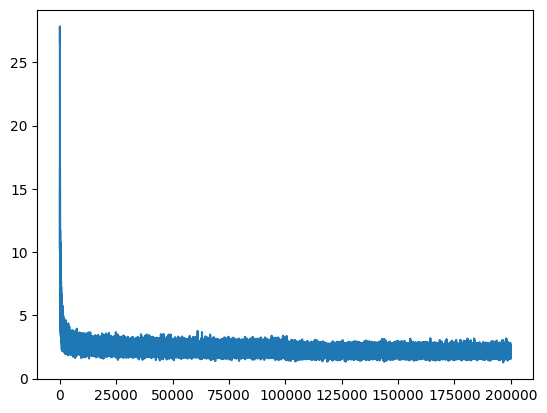

In [30]:
plt.plot(lossi)

In [31]:
@torch.no_grad() # this is to tell PyTorch that we are not going to use the gradients
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xva, Yva),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('val')

train loss: 2.119344472885132
val loss: 2.1626994609832764


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 1)

for _ in range (20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # 1, block_size, n_emb
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window an track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the 'special' token . stop
        if ix == 0:
            break
        
    print(''.join([itos[i] for i in out]))

kamri.
dor.
sley.
emmana.
eiamial.
devi.
ali.
liana.
kinslyn.
jara.
caylonna.
karyan.
ed.
elijuu.
elouela.
izeracheryn.
tyah.
kajoann.
ismaya.
juon.
